In [95]:
import cv2 
import random
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [96]:
def init_img(name):
    img = cv2.imread(name, cv2.IMREAD_GRAYSCALE)

    # Resizing Images
    img = cv2.resize(img,(600,432))
    return img

In [97]:
minHessian = 400
detector = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)

def get_key_desc(img):
    keypoints, descriptors = detector.detectAndCompute(img, None)
    return keypoints, descriptors

In [269]:
from scipy import spatial
def feature_matching(descriptors1, descriptors2):
    tree = spatial.KDTree(descriptors2)
    matches = []

    for i,w in enumerate(descriptors1):
        matches.append((i, tree.query(w, k=2)[1][0], tree.query(w, k=2)[0]))

    # Perform Lowe's Ratio test to remove false matches (Ref: https://docs.opencv.org/3.4/d5/d6f/tutorial_feature_flann_matcher.html)
    ratio_thresh = 0.5
    good_matches = []

    for d1_index, d2_index, nearest_two in matches:
        if nearest_two[0] < ratio_thresh * nearest_two[1]:
            good_matches.append((d1_index, d2_index))

    good_matches = np.array(good_matches)
    return good_matches

In [434]:
def get_points_from_matches(good_matches, k1, k2):
    p1 = []
    p2 = []
    for i in good_matches:
        p1.append(k1[i[0]].pt)
        p2.append(k2[i[1]].pt)
    return p1, p2

In [374]:
# https://math.stackexchange.com/questions/494238/how-to-compute-homography-matrix-h-from-corresponding-points-2d-2d-planar-homog
def homography_matrix(p1, p2):
    n = int(len(p1))
    nrows = 2*n
    ncols = 9
    A = np.zeros((nrows,ncols))
    H = np.zeros((3,3))
    
    for i in range(n):
        x1,y1 = p1[i]
        x2,y2 = p2[i]
        
        A[(2*i),:] = [x1,y1,1,0,0,0,-x1*x2,-y1*x2,-x2]
        A[(2*i)+1,:] = [0,0,0,x1,y1,1,-x1*y2,-y1*y2,-y2]
    
    u, s, vt = np.linalg.svd(A, full_matrices= True)
    h = vt[-1]
    
    H[0], H[1], H[2] = h[:3], h[3:6], h[6:9]
    
    H = H/H[2,2]

    return H

In [373]:
def ransac_model(k1, k2, good_matches):
    max_count = 0
    max_count_H = 0
    npairs = len(good_matches)
    
    for i in range(100):
        if i%10 == 0:
            print(i)
            
        inliers = []
        matches = good_matches[np.random.choice(len(good_matches), size=4, replace=False)]
        k1, k2 = np.array(k1), np.array(k2)
        
        H = homography_matrix([k_1.pt for k_1 in k1[matches.T[0]]], [k_2.pt for k_2 in k2[matches.T[1]]])
        p1, p2 = get_points_from_matches(good_matches, k1, k2)
        
        count = 0
        for point in range(npairs):
            
            curr_point = np.asarray([p1[point][0], p1[point][1], 1]).T
            refer = np.asarray([p2[point][0],p2[point][1],1])
            
            after_H = np.matmul(H, curr_point)
            after_H /= after_H[2]
            
            if np.linalg.norm(after_H - refer) <= 2:
                count += 1
                inliers.append(good_matches[point])
                
        inliers = np.array(inliers)

        if max_count < count:
            max_count = count
            max_count_H = homography_matrix([k_1.pt for k_1 in k1[inliers.T[0]]], [k_2.pt for k_2 in k2[inliers.T[1]]])
            
    print('Homography is ready!')        
    return max_count_H

In [370]:
def add_image(img, H, new_img, x_offset, y_offset):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            operated = H.dot(np.asarray([j,i,1]).T)
            operated /= operated[2]
            operated[0], operated[1] = int(operated[0]), int(operated[1])

            x_, y_ = operated[:2]
            try:
                for tick1 in range(-1,2):
                    for tick1 in range(-1,2):
                        new_img[int(y_ + x_offset + tick1)][int(x_ + y_offset + tick2)] = img[i][j]
            except:
                continue
    return new_img

def warping(img_list, H_list, x_offset, y_offset, x, y):

    new_img = np.zeros((x,y))
    for i in range(img_list[0].shape[0]):
        for j in range(img_list[0].shape[1]):
            new_img[i+x_offset][j+y_offset] = img_list[0][i][j]
            
    for img, H in zip(img_list[1:], H_list):
        new_img = add_image(img, H, new_img, x_offset, y_offset)    
    
    new_img = new_img.astype(np.uint8)
    return new_img

# I1 Dataset 

In [418]:
img1 = init_img('Dataset/I1/a.JPG')
img2 = init_img('Dataset/I1/b.JPG')
img3 = init_img('Dataset/I1/c.JPG')
img4 = init_img('Dataset/I1/d.JPG')
img5 = init_img('Dataset/I1/e.JPG')

k1, d1 = get_key_desc(img1)
k2, d2 = get_key_desc(img2)
k3, d3 = get_key_desc(img3)
k4, d4 = get_key_desc(img4)
k5, d5 = get_key_desc(img5)

In [419]:
# My Implementation
good_matches21 = feature_matching(d2, d1)
good_matches32 = feature_matching(d3, d2)
good_matches43 = feature_matching(d4, d3)
good_matches54 = feature_matching(d5, d4)

H12 = ransac_model(k2, k1, good_matches21)
H13 = np.matmul(H12, ransac_model(k3, k2, good_matches32))
H14 = np.matmul(H13, ransac_model(k4, k3, good_matches43))
H15 = np.matmul(H14, ransac_model(k5, k4, good_matches54))

0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!


In [420]:
x_offset = 800
y_offset = 800
x = 7000
y = 7000

img_list = [img1, img2, img3, img4, img5]
H_list = [H12, H13, H14, H15]

new_img = warping(img_list, H_list, x_offset, y_offset, x, y)

True

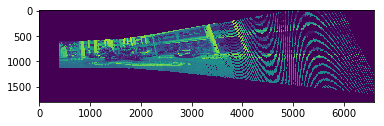

In [422]:
plt.imshow(new_img[200:2000].T[400:9300].T)
cv2.imwrite('Panorama_I1.jpg',new_img[200:2000].T[400:9300].T)

In [448]:
# Inbuilt Functions
p2, p1 = get_points_from_matches(good_matches21, k2, k1)
H12 = cv2.findHomography(np.array(p2), np.array(p1), cv2.RANSAC,4)[0]

p3, p2 = get_points_from_matches(good_matches32, k3, k2)
H13 = np.matmul(H12, cv2.findHomography(np.array(p3), np.array(p2), cv2.RANSAC,4)[0])

p4, p3 = get_points_from_matches(good_matches43, k4, k3)
H14 = np.matmul(H13, cv2.findHomography(np.array(p4), np.array(p3), cv2.RANSAC,4)[0])

p5, p4 = get_points_from_matches(good_matches54, k5, k4)
H15 = np.matmul(H14, cv2.findHomography(np.array(p5), np.array(p4), cv2.RANSAC,4)[0])

In [449]:
x_offset = 800
y_offset = 800
x = 7000
y = 7000

img_list = [img1, img2, img3, img4, img5]
H_list = [H12, H13, H14, H15]

new_img = warping(img_list, H_list, x_offset, y_offset, x, y)

True

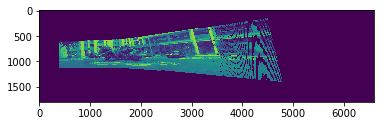

In [451]:
plt.imshow(new_img[200:2000].T[400:9300].T)
cv2.imwrite('Panorama_I1_inbuilt.jpg',new_img[200:2000].T[400:9300].T)

# I2 Dataset

In [453]:
img1 = init_img('Dataset/I2/img60.jpg')
img2 = init_img('Dataset/I2/img63.jpg')
img3 = init_img('Dataset/I2/img66.jpg')
img4 = init_img('Dataset/I2/img69.jpg')
img5 = init_img('Dataset/I2/img72.jpg')

In [454]:
k1, d1 = get_key_desc(img1)
k2, d2 = get_key_desc(img2)
k3, d3 = get_key_desc(img3)
k4, d4 = get_key_desc(img4)
k5, d5 = get_key_desc(img5)

good_matches21 = feature_matching(d2, d1)
good_matches32 = feature_matching(d3, d2)
good_matches43 = feature_matching(d4, d3)
good_matches54 = feature_matching(d5, d4)

H12 = ransac_model(k2, k1, good_matches21)
H13 = np.matmul(H12, ransac_model(k3, k2, good_matches32))
H14 = np.matmul(H13, ransac_model(k4, k3, good_matches43))
H15 = np.matmul(H14, ransac_model(k5, k4, good_matches54))

0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!


In [455]:
x_offset = 800
y_offset = 800
x = 7000
y = 7000

img_list = [img1, img2, img3, img4, img5]
H_list = [H12, H13, H14, H15]

new_img = warping(img_list, H_list, x_offset, y_offset, x, y)

True

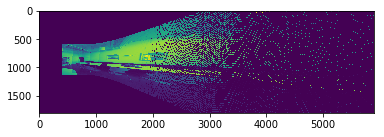

In [458]:
plt.imshow(new_img[200:2000].T[400:6300].T)
cv2.imwrite('Panorama_I2.jpg',new_img[200:2000].T[400:6300].T)

In [459]:
# Inbuilt Functions
p2, p1 = get_points_from_matches(good_matches21, k2, k1)
H12 = cv2.findHomography(np.array(p2), np.array(p1), cv2.RANSAC,4)[0]

p3, p2 = get_points_from_matches(good_matches32, k3, k2)
H13 = np.matmul(H12, cv2.findHomography(np.array(p3), np.array(p2), cv2.RANSAC,4)[0])

p4, p3 = get_points_from_matches(good_matches43, k4, k3)
H14 = np.matmul(H13, cv2.findHomography(np.array(p4), np.array(p3), cv2.RANSAC,4)[0])

p5, p4 = get_points_from_matches(good_matches54, k5, k4)
H15 = np.matmul(H14, cv2.findHomography(np.array(p5), np.array(p4), cv2.RANSAC,4)[0])

In [460]:
x_offset = 800
y_offset = 800
x = 7000
y = 7000

img_list = [img1, img2, img3, img4, img5]
H_list = [H12, H13, H14, H15]

new_img = warping(img_list, H_list, x_offset, y_offset, x, y)

True

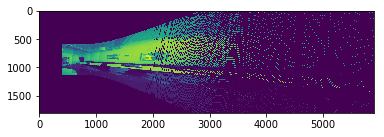

In [462]:
plt.imshow(new_img[200:2000].T[400:6300].T)
cv2.imwrite('Panorama_I2_inbuilt.jpg',new_img[200:2000].T[400:6300].T)

# I3 Dataset

In [463]:
img1 = init_img('Dataset/I3/img30.jpg')
img2 = init_img('Dataset/I3/img33.jpg')
img3 = init_img('Dataset/I3/img36.jpg')
img4 = init_img('Dataset/I3/img39.jpg')
img5 = init_img('Dataset/I3/img42.jpg')

In [464]:
k1, d1 = get_key_desc(img1)
k2, d2 = get_key_desc(img2)
k3, d3 = get_key_desc(img3)
k4, d4 = get_key_desc(img4)
k5, d5 = get_key_desc(img5)

good_matches21 = feature_matching(d2, d1)
good_matches32 = feature_matching(d3, d2)
good_matches43 = feature_matching(d4, d3)
good_matches54 = feature_matching(d5, d4)

H12 = ransac_model(k2, k1, good_matches21)
H13 = np.matmul(H12, ransac_model(k3, k2, good_matches32))
H14 = np.matmul(H13, ransac_model(k4, k3, good_matches43))
H15 = np.matmul(H14, ransac_model(k5, k4, good_matches54))

0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!


In [465]:
x_offset = 800
y_offset = 800
x = 7000
y = 7000

img_list = [img1, img2, img3, img4, img5]
H_list = [H12, H13, H14, H15]

new_img = warping(img_list, H_list, x_offset, y_offset, x, y)

True

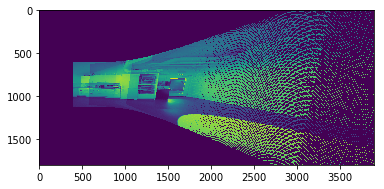

In [470]:
plt.imshow(new_img[200:2000].T[400:4300].T)
cv2.imwrite('Panorama_I3.jpg',new_img[200:2000].T[400:4300].T)

In [471]:
# Inbuilt Functions
p2, p1 = get_points_from_matches(good_matches21, k2, k1)
H12 = cv2.findHomography(np.array(p2), np.array(p1), cv2.RANSAC,4)[0]

p3, p2 = get_points_from_matches(good_matches32, k3, k2)
H13 = np.matmul(H12, cv2.findHomography(np.array(p3), np.array(p2), cv2.RANSAC,4)[0])

p4, p3 = get_points_from_matches(good_matches43, k4, k3)
H14 = np.matmul(H13, cv2.findHomography(np.array(p4), np.array(p3), cv2.RANSAC,4)[0])

p5, p4 = get_points_from_matches(good_matches54, k5, k4)
H15 = np.matmul(H14, cv2.findHomography(np.array(p5), np.array(p4), cv2.RANSAC,4)[0])

In [472]:
x_offset = 800
y_offset = 800
x = 7000
y = 7000

img_list = [img1, img2, img3, img4, img5]
H_list = [H12, H13, H14, H15]

new_img = warping(img_list, H_list, x_offset, y_offset, x, y)

True

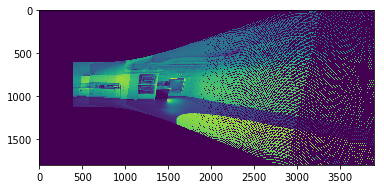

In [473]:
plt.imshow(new_img[200:2000].T[400:4300].T)
cv2.imwrite('Panorama_I3_inbuilt.jpg',new_img[200:2000].T[400:4300].T)

# I4 Dataset

In [474]:
img1 = init_img('Dataset/I4/a.JPG')
img2 = init_img('Dataset/I4/b.JPG')
img3 = init_img('Dataset/I4/c.JPG')
img4 = init_img('Dataset/I4/d.JPG')
img5 = init_img('Dataset/I4/e.JPG')

In [475]:
k1, d1 = get_key_desc(img1)
k2, d2 = get_key_desc(img2)
k3, d3 = get_key_desc(img3)
k4, d4 = get_key_desc(img4)
k5, d5 = get_key_desc(img5)

good_matches21 = feature_matching(d2, d1)
good_matches32 = feature_matching(d3, d2)
good_matches43 = feature_matching(d4, d3)
good_matches54 = feature_matching(d5, d4)

H12 = ransac_model(k2, k1, good_matches21)
H13 = np.matmul(H12, ransac_model(k3, k2, good_matches32))
H14 = np.matmul(H13, ransac_model(k4, k3, good_matches43))
H15 = np.matmul(H14, ransac_model(k5, k4, good_matches54))

0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!


In [476]:
x_offset = 800
y_offset = 800
x = 7000
y = 7000

img_list = [img1, img2, img3, img4, img5]
H_list = [H12, H13, H14, H15]

new_img = warping(img_list, H_list, x_offset, y_offset, x, y)

True

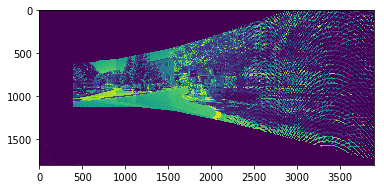

In [480]:
plt.imshow(new_img[200:2000].T[400:4300].T)
cv2.imwrite('Panorama_I4.jpg',new_img[200:2000].T[400:4300].T)

In [481]:
# Inbuilt Functions
p2, p1 = get_points_from_matches(good_matches21, k2, k1)
H12 = cv2.findHomography(np.array(p2), np.array(p1), cv2.RANSAC,4)[0]

p3, p2 = get_points_from_matches(good_matches32, k3, k2)
H13 = np.matmul(H12, cv2.findHomography(np.array(p3), np.array(p2), cv2.RANSAC,4)[0])

p4, p3 = get_points_from_matches(good_matches43, k4, k3)
H14 = np.matmul(H13, cv2.findHomography(np.array(p4), np.array(p3), cv2.RANSAC,4)[0])

p5, p4 = get_points_from_matches(good_matches54, k5, k4)
H15 = np.matmul(H14, cv2.findHomography(np.array(p5), np.array(p4), cv2.RANSAC,4)[0])

In [482]:
x_offset = 800
y_offset = 800
x = 7000
y = 7000

img_list = [img1, img2, img3, img4, img5]
H_list = [H12, H13, H14, H15]

new_img = warping(img_list, H_list, x_offset, y_offset, x, y)

True

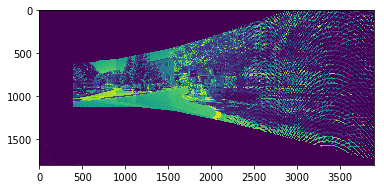

In [483]:
plt.imshow(new_img[200:2000].T[400:4300].T)
cv2.imwrite('Panorama_I4_inbuilt.jpg',new_img[200:2000].T[400:4300].T)

# I5 Dataset

In [484]:
img1 = init_img('Dataset/I5/a.JPG')
img2 = init_img('Dataset/I5/b.JPG')
img3 = init_img('Dataset/I5/c.JPG')
img4 = init_img('Dataset/I5/d.JPG')
img5 = init_img('Dataset/I5/e.JPG')

In [485]:
k1, d1 = get_key_desc(img1)
k2, d2 = get_key_desc(img2)
k3, d3 = get_key_desc(img3)
k4, d4 = get_key_desc(img4)
k5, d5 = get_key_desc(img5)

good_matches21 = feature_matching(d2, d1)
good_matches32 = feature_matching(d3, d2)
good_matches43 = feature_matching(d4, d3)
good_matches54 = feature_matching(d5, d4)

H12 = ransac_model(k2, k1, good_matches21)
H13 = np.matmul(H12, ransac_model(k3, k2, good_matches32))
H14 = np.matmul(H13, ransac_model(k4, k3, good_matches43))
H15 = np.matmul(H14, ransac_model(k5, k4, good_matches54))

0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!
0
10
20
30
40
50
60
70
80
90
Homography is ready!


In [486]:
x_offset = 800
y_offset = 800
x = 7000
y = 7000

img_list = [img1, img2, img3, img4, img5]
H_list = [H12, H13, H14, H15]

new_img = warping(img_list, H_list, x_offset, y_offset, x, y)

True

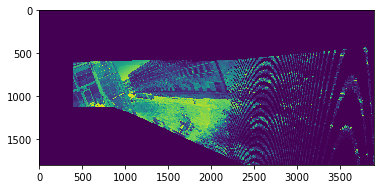

In [488]:
plt.imshow(new_img[200:2000].T[400:4300].T)
cv2.imwrite('Panorama_I5.jpg',new_img[200:2000].T[400:4300].T)

In [489]:
# Inbuilt Functions
p2, p1 = get_points_from_matches(good_matches21, k2, k1)
H12 = cv2.findHomography(np.array(p2), np.array(p1), cv2.RANSAC,4)[0]

p3, p2 = get_points_from_matches(good_matches32, k3, k2)
H13 = np.matmul(H12, cv2.findHomography(np.array(p3), np.array(p2), cv2.RANSAC,4)[0])

p4, p3 = get_points_from_matches(good_matches43, k4, k3)
H14 = np.matmul(H13, cv2.findHomography(np.array(p4), np.array(p3), cv2.RANSAC,4)[0])

p5, p4 = get_points_from_matches(good_matches54, k5, k4)
H15 = np.matmul(H14, cv2.findHomography(np.array(p5), np.array(p4), cv2.RANSAC,4)[0])

In [490]:
x_offset = 800
y_offset = 800
x = 7000
y = 7000

img_list = [img1, img2, img3, img4, img5]
H_list = [H12, H13, H14, H15]

new_img = warping(img_list, H_list, x_offset, y_offset, x, y)

True

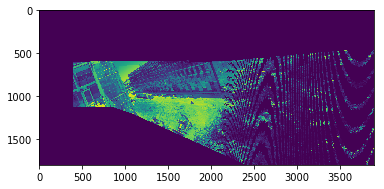

In [491]:
plt.imshow(new_img[200:2000].T[400:4300].T)
cv2.imwrite('Panorama_I5_inbuilt.jpg',new_img[200:2000].T[400:4300].T)